<a href="https://colab.research.google.com/github/dshakes90/AMP-largescale-CNN-VGG-audio-classification/blob/master/MTG_Jamendo12_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis of Essentia models on the MTG-Jamendo dataset
> Dougal Shakespeare, dougalian.shakespeare01@estudiant.upf.edu




---
The task consists of three parts: 

*   Listen to a collection of audio and annotate it with some characteristics split into two groups. You have to run the annotation process separately for each group.
*   Take the pre-existing models that predict these characteristics and process the audio, gathering predictions.
*   Perform an analysis of the accuracy of the models compared to your annotations and write a report.

In this task, we will perform predictions and evaluation on chunk 12 of the MTG-Jamendo dataset [1].

---
[1]: https://mtg.github.io/mtg-jamendo-dataset/

## 0.0 Pre-processing and Setup

### 0.1 Ground Truth annotation and audio clip downloads: 
If you wish to replicate the results from this study, please download the ground truth annotations and audio clips from chunk 12 or the MTG-Jamendo dataset from the following links:

> https://drive.google.com/drive/folders/1WVISvvYzpBU8LuBCc2yYNNP8KYcnC8vQ?usp=sharing

> https://drive.google.com/drive/folders/1Xz6HoygFdQcr10qx6yUXTTo254YaKEvD

The 'annotations' folder should be downloaded to your own personal drive such that it is stored in your local path: `drive/My Drive/annotations/`

Store all audio clips in the following local path: `drive/My Drive/tracks`

## 0.2 TensorFlow models for Essentia downloads:
It is also required to download the all CNN and VGGish models to classify mood and miscellanious. This can be done manually via the following link:

> https://mtg.github.io/essentia-labs/news/2020/01/16/tensorflow-models-released/

or allternitively by running the cell block below. Assert that files are downloaded to `drive/My Drive/essentia-tensorflow-models` or too a modified file path of your choice :p 



In [0]:
# install esentia-tensorflow if not allready installed on colab
!pip install essentia-tensorflow -f https://essentia.upf.edu/python-wheels/

Looking in links: https://essentia.upf.edu/python-wheels/
     |████████████████████████████████| 380.7MB 49kB/s 


In [0]:
# Option (2); install all CNN and VGGish models...
!wget https://essentia.upf.edu/models/classifiers/danceability/danceability-musicnn-msd.pb

In [0]:
import numpy as np
from essentia.standard import *
import os
import json

In [0]:
# mount drive to access ground truth annotation files
from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# assert we are connected to gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# file paths to Drives
track_file_path = 'drive/My Drive/tracks'     #path of chunk 12 of MTG-Jamendo dataset
ground_truths = 'drive/My Drive/annotations/' #path of manually annotated json
graph_file_path = 'drive/My Drive/essentia-tensorflow-models' #path of installed essentia CNN and VGGish models

# file paths to result folders, currently empty
mood_file_path = graph_file_path + '/mood/'
miscellaneous_file_path = graph_file_path + '/miscellaneous/'
json_results = 'drive/My Drive/ampresults1/'

In [0]:
# if result folders do not exist, create...
def create_folders(newpath): 
  if not os.path.exists(newpath):
      os.makedirs(newpath)
  else: print('folder: {} allready exists'.format(newpath))

# create folders!
create_folders(mood_file_path)
create_folders(miscellaneous_file_path)
create_folders(json_results)

folder: drive/My Drive/essentia-tensorflow-models/mood/ allready exists
folder: drive/My Drive/essentia-tensorflow-models/miscellaneous/ allready exists
folder: drive/My Drive/ampresults1/ allready exists


In [0]:
## collect all paths to audio files 
track_paths = []

for folder_name in os.listdir(track_file_path):
    if folder_name[-4:] != 'keep':
        folder_path = track_file_path + '/' + folder_name
        for file_name in os.listdir(folder_path):
            track_path = folder_path + '/' + file_name
            track_paths.append(track_path)

print('- track_paths contains:', len(track_paths), 'tracks.')

- track_paths contains: 579 tracks.


In [0]:
# collection of graph paths for mood and miscilanious
mood_vggish_graphs = []
mood_cnn_graphs = []
miscellaneous_vggish_graphs = []
miscellaneous_cnn_graphs = []

for mood_graph in os.listdir(mood_file_path):
    if 'vggish' in mood_graph:
        mood_vggish_graphs.append(mood_file_path + mood_graph)
    else: mood_cnn_graphs.append(mood_file_path + mood_graph)

for miscellaneous_graph in os.listdir(miscellaneous_file_path):
    if 'vggish' in miscellaneous_graph:
        miscellaneous_vggish_graphs.append(miscellaneous_file_path + miscellaneous_graph)
    else: miscellaneous_cnn_graphs.append(miscellaneous_file_path + miscellaneous_graph)

## 1.0 Run predictions using CNN and VGGish Models


In [0]:
# Get mean prediction and return top ranking label 
def get_prediction(predictions):
  predictions = np.mean(predictions, axis=0)
  print(predictions)
  value = np.argmax(predictions)

  # if we consider index 1 as maximum, we have classified as negation of class 
  if value == 1:
    return 0
  else: return 1

In [0]:
def classify_mood_vgg(audio, path):
  mood_vgg_results = dict()  # dictionary to write to json
  basename = os.path.basename(path)[:-4] # retrieve name of just audio file
  json_path = json_results + 'moodvgg-' + basename + '-results.json' # for each audio clip write results to json

  # if we have not allready processed this file, continue...
  if test_json_exists(json_path) == False:
    for vgg_graph in mood_vggish_graphs:
      model_name_split = vgg_graph.split('/')
      model_name = model_name_split[len(model_name_split)-1][:-3]
      model_class = model_name.split('-')[0]

      # make prediction
      model = TensorflowPredictVGGish(graphFilename=vgg_graph)
      predictions = model(audio)

      # get class of prediction
      chosen_prediction = get_prediction(predictions)
      # update dict.
      mood_vgg_results[model_class] = chosen_prediction

    # done dump dictionary to json
    dump_json(json_path, mood_vgg_results)

In [0]:
def classify_mood_cnn(audio, path):
  mood_cnn_results = dict() # dictionary to write to json
  basename = os.path.basename(path)[:-4] # retrieve name of just audio file
  json_path = json_results + 'moodcnn-' + basename + '-results.json' # for each audio clip write results to json

  # if we have not allready processed this file, continue...
  if test_json_exists(json_path) == False:
    for cnn_graph in mood_cnn_graphs:
      model_name_split = cnn_graph.split('/')
      model_name = model_name_split[len(model_name_split)-1][:-3]
      model_class = model_name.split('-')[0]

      # make prediction
      model = TensorflowPredictMusiCNN(graphFilename=cnn_graph)
      predictions = model(audio)

      # get class of prediction
      chosen_prediction = get_prediction(predictions)
      # update dict.
      mood_cnn_results[model_class] = chosen_prediction
      
    # done dump dictionary to json
    dump_json(json_path, mood_cnn_results)

In [0]:
def classify_miscellaneous_cnn(audio, path):
  miscellaneous_cnn_results = dict()   # dictionary to write to json
  basename = os.path.basename(path)[:-4] # retrieve name of just audio file
  json_path = json_results + 'miscellaneouscnn-' + basename + '-results.json' # for each audio clip write results to json

  # if we have not allready processed this file, continue...
  if test_json_exists(json_path) == False:
    for cnn_graph in miscellaneous_cnn_graphs:
      model_name_split = cnn_graph.split('/')
      model_name = model_name_split[len(model_name_split)-1][:-3]
      model_class = model_name.split('-')[0]

      # make prediction
      model = TensorflowPredictMusiCNN(graphFilename=cnn_graph)
      predictions = model(audio)

      # get class of prediction
      chosen_prediction = get_prediction(predictions)
      # update dict.
      miscellaneous_cnn_results[model_class] = chosen_prediction

    # done dump dictionary to json
    dump_json(json_path, miscellaneous_cnn_results)

In [0]:
def classify_miscellaneous_vgg(audio, path):
  miscellaneous_vgg_results = dict() # dictionary to write to json
  basename = os.path.basename(path)[:-4] # retrieve name of just audio file
  json_path = json_results + 'miscellaneousvgg-' + basename + '-results.json' # for each audio clip write results to json

  # if we have not allready processed this file, continue...
  if test_json_exists(json_path) == False:
    for vgg_graph in miscellaneous_vggish_graphs:
      model_name_split = vgg_graph.split('/')
      model_name = model_name_split[len(model_name_split)-1][:-3]
      model_class = model_name.split('-')[0]

      # make prediction
      model = TensorflowPredictVGGish(graphFilename=vgg_graph)
      predictions = model(audio)

      # get class of prediction
      chosen_prediction = get_prediction(predictions)
      # update dict.
      miscellaneous_vgg_results[model_class] = chosen_prediction

    # done dump dictionary to json
    dump_json(json_path, miscellaneous_vgg_results)

In [0]:
def dump_json(datafile, prediction):
  with open(datafile, "w+") as fp:
    json.dump(prediction, fp)

In [0]:
def test_json_exists(datafile):
  if os.path.exists(datafile):
    print("Already computed {}".format(datafile))
    return True
  else: 
    print('json does not exist!')
    return False

In [0]:
# helper function to check if all json files exist for track...
def check_json_exists(basename):
  # init variables
  mood_vgg = test_json_exists(json_results + 'moodvgg-' + basename + '-results.json')
  mood_cnn = test_json_exists(json_results + 'moodcnn-' + basename + '-results.json')
  misc_vgg = test_json_exists(json_results + 'miscellaneousvgg-' + basename + '-results.json')
  misc_cnn = test_json_exists(json_results + 'miscellaneouscnn-' + basename + '-results.json')

  # if at least one of these file paths does not exist, return true
  if mood_vgg or mood_cnn or misc_vgg or misc_cnn:
    return False
  else: return True

## Main logic - run transfer learning for all VGGish and CNN models
i = 0 #track counter

for track in track_paths:
  print(i/len(track_paths), '%')
  basename = os.path.basename(track)[:-4]

  # if we have not yet classifed this file...
  if check_json_exists(basename):

    # limit audio size to reduce kernal overload
    audio = EasyLoader(filename=track, sampleRate=16000, endTime=180)()

    # (1) classify for all mood_vggish models
    print('mood classification with vggs')
    classify_mood_vgg(audio, track)
    print('')

    # (2) classify for all mood_cnn models
    print('mood classification with cnns')
    classify_mood_cnn(audio, track)
    print('')

    # (3) classify for all miscellaneous_vggish models
    print('miscellaneous classification with vggs')
    classify_miscellaneous_vgg(audio, track)
    print('')

    # (4) classify for all miscellaneous_cnn models
    print('miscellaneous classification with cnns')
    classify_miscellaneous_cnn(audio, track)
    print('')

  i+=1 #next track

i value: 0
0.0 %
1281567
Already computed drive/My Drive/ampresults1/moodvgg-1281567-results.json
Already computed drive/My Drive/ampresults1/moodcnn-1281567-results.json
Already computed drive/My Drive/ampresults1/miscellaneousvgg-1281567-results.json
Already computed drive/My Drive/ampresults1/miscellaneouscnn-1281567-results.json
i value: 1
0.0017271157167530224 %
1355267
Already computed drive/My Drive/ampresults1/moodvgg-1355267-results.json
Already computed drive/My Drive/ampresults1/moodcnn-1355267-results.json
Already computed drive/My Drive/ampresults1/miscellaneousvgg-1355267-results.json
Already computed drive/My Drive/ampresults1/miscellaneouscnn-1355267-results.json
i value: 2
0.0034542314335060447 %
1389967
Already computed drive/My Drive/ampresults1/moodvgg-1389967-results.json
Already computed drive/My Drive/ampresults1/moodcnn-1389967-results.json
Already computed drive/My Drive/ampresults1/miscellaneousvgg-1389967-results.json
Already computed drive/My Drive/ampresult

## 2.0 Measure the Accuracy of the Classifications

### 2.1 Compute Accuracy for CNN and VGGish

In [0]:
results_dict = {} # load file paths into a dict so they are easier to manage

for result in os.listdir(json_results):
  if result != '.ipynb_checkpoints':
    path = json_results + result
    split_results = result.split('-')
    track_id = split_results[1]

    if track_id in results_dict:
        # append the new number to the existing array at this slot
        results_dict[track_id].append(path)
    else:
        # create a new array in this slot
        results_dict[track_id] = [path]

In [0]:
# repeat for ground truths sothey are eaiser to managae:
gt_dict = {} # load file paths into a dict so they are easier to manage

for result in os.listdir(ground_truths):
  if result != '.ipynb_checkpoints':
    path = ground_truths + result
    track_id = result.split('_')[-1].split('.')[0]

    if track_id in gt_dict:
      # append the new number to the existing array at this slot
      gt_dict[track_id].append(path)
    else:
      # create a new array in this slot
      gt_dict[track_id] = [path]

In [0]:
## Compute classification accuracy

# classification classes
mood_classes = ['mood_acoustic', 'mood_aggressive', 'mood_electronic', 'mood_happy',
                'mood_party', 'mood_relaxed', 'mood_sad']
misc_classes = ['danceability', 'gender', 'tonal_atonal', 'voice_instrumental']

mood_cnn_allclassifications = []
mood_vgg_allclassifications = []
mood_gt_allclassifications = []
misc_cnn_allclassifications = []
misc_vgg_allclassifications = []
misc_gt_allclassifications = []

i = 0 #debug count
for track in track_paths:
  #print(track)
  print('progress:', i/len(track_paths))

  basename = os.path.basename(track)[:-4] # retrieve name of just audio file
  results = results_dict[basename]

  # file paths to ground truth results 
  if 'mood' in gt_dict[basename][0]:
    gt_results_mood = gt_dict[basename][0]
    gt_results_misc = gt_dict[basename][1]
  else: 
    gt_results_mood = gt_dict[basename][1]
    gt_results_misc = gt_dict[basename][0]

  mood_results = results_dict[basename][:2]
  misc_results = results_dict[basename][2:]

  mood_results_vgg = mood_results[0]
  mood_results_cnn = mood_results[1]
  misc_results_vgg = misc_results[0]
  misc_results_cnn = misc_results[1]

  with open(mood_results_vgg) as mood_vgg, open(mood_results_cnn) as mood_cnn, open(misc_results_vgg) as misc_vgg, open(misc_results_cnn) as misc_cnn, open(gt_results_mood) as mood_gt, open(gt_results_misc) as misc_gt:  
    #results from classifications
    mood_vgg_dict = json.load(mood_vgg)
    mood_cnn_dict = json.load(mood_cnn)
    misc_vgg_dict = json.load(misc_vgg)
    misc_cnn_dict = json.load(misc_cnn)
    #ground truth dicts
    gt_mood = json.load(mood_gt) 
    gt_misc = json.load(misc_gt) 

  for c in mood_classes:
    print(mood_vgg_dict)
    print(mood_cnn_dict)
    print(gt_mood)

    mood_vgg_allclassifications.append(mood_vgg_dict[c])
    mood_cnn_allclassifications.append(mood_cnn_dict[c])
    mood_gt_allclassifications.append(gt_mood[c])

  for c in misc_classes:
    misc_vgg_allclassifications.append(misc_vgg_dict[c])
    misc_cnn_allclassifications.append(misc_cnn_dict[c])
    misc_gt_allclassifications.append(gt_misc[c])
  
  i+=1 #next track

Streaming output truncated to the last 5000 lines.
{'mood_acoustic': 0, 'mood_aggressive': 0, 'mood_electronic': 1, 'mood_happy': 0, 'mood_party': 1, 'mood_relaxed': 0, 'mood_sad': 1}
{'mood_acoustic': '0', 'mood_electronic': '1', 'mood_aggressive': '0', 'mood_relaxed': '1', 'mood_happy': '0', 'mood_sad': '0', 'mood_party': '1'}
{'mood_acoustic': 0, 'mood_aggressive': 0, 'mood_electronic': 1, 'mood_happy': 0, 'mood_party': 0, 'mood_relaxed': 1, 'mood_sad': 1}
{'mood_acoustic': 0, 'mood_aggressive': 0, 'mood_electronic': 1, 'mood_happy': 0, 'mood_party': 1, 'mood_relaxed': 0, 'mood_sad': 1}
{'mood_acoustic': '0', 'mood_electronic': '1', 'mood_aggressive': '0', 'mood_relaxed': '1', 'mood_happy': '0', 'mood_sad': '0', 'mood_party': '1'}
progress: 0.6079447322970639
{'mood_acoustic': 0, 'mood_aggressive': 0, 'mood_electronic': 0, 'mood_happy': 0, 'mood_party': 1, 'mood_relaxed': 0, 'mood_sad': 0}
{'mood_acoustic': 1, 'mood_aggressive': 0, 'mood_electronic': 1, 'mood_happy': 0, 'mood_party'

In [0]:
from sklearn.metrics import accuracy_score

mood_gt_allclassifications = list(map(int, mood_gt_allclassifications))
misc_gt_allclassifications = list(map(int, misc_gt_allclassifications))

## Accuracy socres:
cnn_mood_accuracy = accuracy_score(mood_gt_allclassifications, mood_cnn_allclassifications)
cnn_misc_accuracy = accuracy_score(misc_gt_allclassifications, misc_cnn_allclassifications)
vgg_mood_accuracy = accuracy_score(mood_gt_allclassifications, mood_vgg_allclassifications)
vgg_misc_accuracy = accuracy_score(misc_gt_allclassifications, misc_vgg_allclassifications)

## Output results:
print('--- CNN CLASSIFICATION RESULTS ---')
print('Accuracy for cnn: mood', cnn_mood_accuracy)
print('Accuracy for cnn: misc', cnn_misc_accuracy)
print('\n--- VGG CLASSIFICATION RESULTS ---')
print('Accuracy for vgg: mood', vgg_mood_accuracy)
print('Accuracy for vgg: misc', vgg_misc_accuracy)

--- CNN CLASSIFICATION RESULTS ---
Accuracy for cnn: mood 0.5351591413767579
Accuracy for cnn: misc 0.483160621761658

--- VGG CLASSIFICATION RESULTS ---
Accuracy for vgg: mood 0.540340488527017
Accuracy for vgg: misc 0.42357512953367876


From our results we observe that the CNN produced slightly higher accuracy results for both mood and misc. Thus, we will plot confusion matracies for these.

## 2.2 Mood Confusion Matrices

In [0]:
# confusion matracies plotting for CNN

# dictionaries to store results to plot confusion matracies
mood_cnn_allclassifications = {'mood_acoustic': [], 'mood_aggressive' : [], 
                               'mood_electronic' : [], 'mood_happy' : [],
                               'mood_party' : [], 'mood_relaxed' : [], 'mood_sad' : []}


misc_cnn_allclassifications = {'danceability' : [], 'gender' : [], 'tonal_atonal' : [], 
                               'voice_instrumental' : []}

mood_gt_allclassifications = {'mood_acoustic': [], 'mood_aggressive' : [], 
                               'mood_electronic' : [], 'mood_happy' : [],
                               'mood_party' : [], 'mood_relaxed' : [], 'mood_sad' : []}


misc_gt_allclassifications = {'danceability' : [], 'gender' : [], 'tonal_atonal' : [], 
                               'voice_instrumental' : []}

i = 0 #debug count

#consider every track...
for track in track_paths:
  basename = os.path.basename(track)[:-4] # retrieve name of just audio file
  results = results_dict[basename]

  # file paths to ground truth results 
  if 'mood' in gt_dict[basename][0]:
    gt_results_mood = gt_dict[basename][0]
    gt_results_misc = gt_dict[basename][1]
  else: 
    gt_results_mood = gt_dict[basename][1]
    gt_results_misc = gt_dict[basename][0]

  mood_results = results_dict[basename][:2]
  misc_results = results_dict[basename][2:]
  mood_results_cnn = mood_results[1]
  misc_results_cnn = misc_results[1]

  with open(mood_results_cnn) as mood_cnn, open(misc_results_cnn) as misc_cnn, open(gt_results_mood) as mood_gt, open(gt_results_misc) as misc_gt:  

    #results from classifications
    mood_cnn_dict = json.load(mood_cnn)
    misc_cnn_dict = json.load(misc_cnn)
    #ground truth dicts
    gt_mood = json.load(mood_gt) 
    gt_misc = json.load(misc_gt) 

  for mood_class in mood_gt_allclassifications.keys():
    mood_cnn_allclassifications[mood_class].append(mood_cnn_dict[mood_class])
    mood_gt_allclassifications[mood_class].append(gt_mood[mood_class])

  for misc_class in misc_gt_allclassifications.keys():
    misc_cnn_allclassifications[misc_class].append(misc_cnn_dict[misc_class])
    misc_gt_allclassifications[misc_class].append(gt_misc[misc_class])

  i+=1 #next audio track

Class: mood_acoustic
[[0.76615385 0.23384615]
 [0.28740157 0.71259843]]


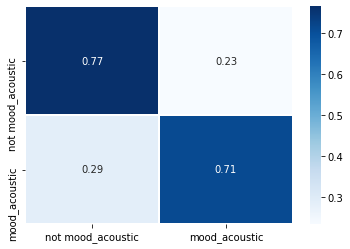

Class: mood_aggressive
[[0.96794872 0.03205128]
 [0.65765766 0.34234234]]


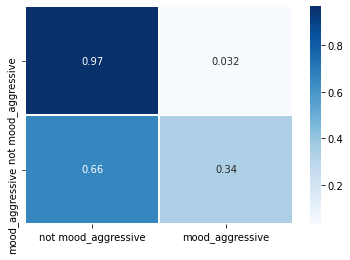

Class: mood_electronic
[[0.80514706 0.19485294]
 [0.24429967 0.75570033]]


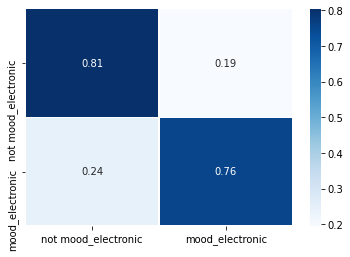

Class: mood_happy
[[0.8449848 0.1550152]
 [0.66      0.34     ]]


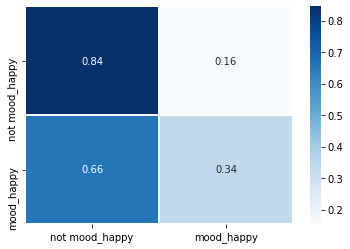

Class: mood_party
[[0.03587444 0.96412556]
 [0.51879699 0.48120301]]


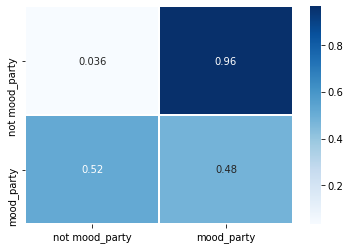

Class: mood_relaxed
[[0.49689441 0.50310559]
 [0.82057416 0.17942584]]


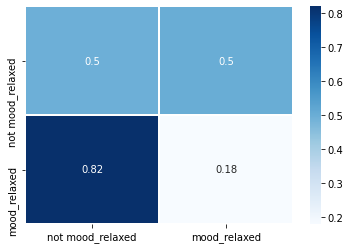

Class: mood_sad
[[0.40963855 0.59036145]
 [0.82317073 0.17682927]]


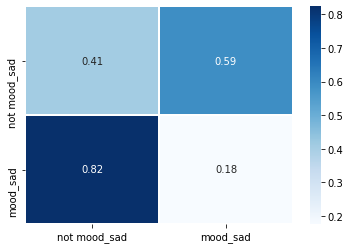

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pylab as plt

# plot all confusion matrix for mood...
for mood_class in mood_gt_allclassifications.keys():
  print('Class:', mood_class)
  matrix_test = confusion_matrix(list(map(int, mood_gt_allclassifications[mood_class])), mood_cnn_allclassifications[mood_class], normalize='true')
  print(matrix_test)
  ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['not ' + mood_class, mood_class], yticklabels= ['not ' + mood_class, mood_class])
  plt.show()

### 2.3 Misc Confusion Matrices

Class: danceability
[[0.72019465 0.27980535]
 [0.14285714 0.85714286]]


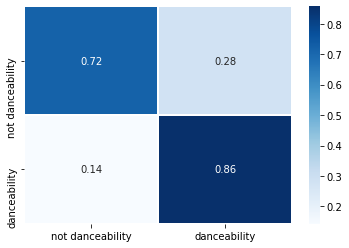

Class: gender
ysss
[[0.94067797 0.05932203 0.        ]
 [0.38709677 0.61290323 0.        ]
 [0.30930233 0.69069767 0.        ]]


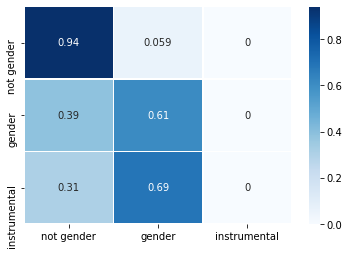

Class: tonal_atonal
[[0.01724138 0.98275862]
 [0.18618042 0.81381958]]


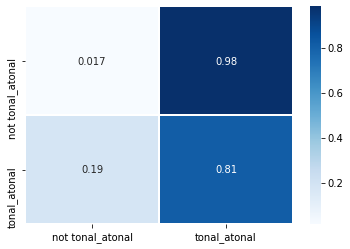

Class: voice_instrumental
[[0.24065421 0.75934579]
 [0.86092715 0.13907285]]


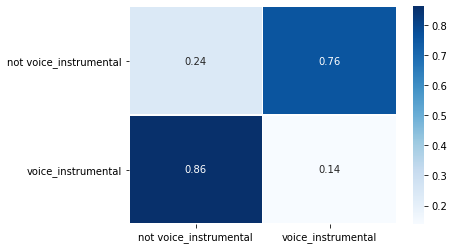

In [0]:
# plot all confusion matrix for misc...
for misc_class in misc_gt_allclassifications.keys():
  print('Class:', misc_class)

  if misc_class == 'gender':
    print('ysss')
    label = ['male', 'female', 'instrumental']
    matrix_test = confusion_matrix(list(map(int, misc_gt_allclassifications[misc_class])), misc_cnn_allclassifications[misc_class], normalize='true')
    print(matrix_test)
    ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= label, yticklabels= label)
    plt.show()
  else:
    matrix_test = confusion_matrix(list(map(int, misc_gt_allclassifications[misc_class])), misc_cnn_allclassifications[misc_class], normalize='true')
    print(matrix_test)
    ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['not ' + misc_class, misc_class], yticklabels= ['not ' + misc_class, misc_class])
    plt.show()